## Download the Dataset

In [1]:
!wget http://www.cs.stir.ac.uk/~lss/arabic/Dataset_30_Sep.zip
!unzip Dataset_30_Sep.zip >> tmp.txt

--2019-08-02 17:03:36--  http://www.cs.stir.ac.uk/~lss/arabic/Dataset_30_Sep.zip
Resolving www.cs.stir.ac.uk (www.cs.stir.ac.uk)... 139.153.254.70
Connecting to www.cs.stir.ac.uk (www.cs.stir.ac.uk)|139.153.254.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 845051294 (806M) [application/zip]
Saving to: ‘Dataset_30_Sep.zip’

Dataset_30_Sep.zip  100%[===================>] 805.90M  9.63MB/s    in 86s     

2019-08-02 17:05:03 (9.33 MB/s) - ‘Dataset_30_Sep.zip’ saved [845051294/845051294]



## Imports

In [0]:
import tarfile
import IPython.display as ipd
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
from tensorflow.python.ops import io_ops
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import os 
import glob
from random import shuffle
import numpy as np
from scipy.signal import resample
import random
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, Dense, Flatten, Dropout
import tensorflow

We can then test some samples by drawing the sound signal 

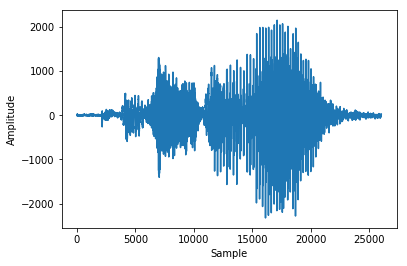

In [3]:
sample_audio_file = 'Dataset_30_Sep/S13.09.10.wav'

samplingFrequency, signalData = wavfile.read(sample_audio_file)

#this comes with two identitcal signals, just draw one
plt.plot(signalData[:,0])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Test the  sound of a random sample

In [4]:
ipd.Audio(sample_audio_file)

The dataset contains around 20 labels we are only interested in the digits

In [0]:
label2name = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
name2label = {label2name[key]:key for key in range(10)}

The names comes in the format S01.01.01 where the first one is the speacker id, the second one is the repition id and the last is the label. Each speaker repeats the same word 10 times.



In [0]:
paths = []
labels = []

#only add the digits labeled 01-10
paths = paths + glob.glob('Dataset_30_Sep/**0[0-9].wav')
paths = paths + glob.glob('Dataset_30_Sep/**.10.wav')
shuffle(paths)

## Data Loading

We use generators to generate batches of (data, label) pairs. 

In [0]:
#we crop the samples in a maximum size of 44100 
CROP_SIZE = 44100

In [0]:
#get the id from the path
def get_label_id(path):
  label = path[-6:-4]
  if label[0] == '.':
    label = label[1:]
    
  return int(label) - 1

def data_generator(paths, batch_size = 32, train = True):
  
  while True:
    batch_paths = np.random.choice(a= paths, size = batch_size)
    
    batch_input = []
    batch_output = []
    
    for path in batch_paths:
      _, input = wavfile.read(path)
      input = input[:,0]
        
      #only pad short indices
      if len(input) - CROP_SIZE < 0:
        input = np.pad(input, (0, CROP_SIZE - len(input)), mode = 'constant')
      
      input = input[0:CROP_SIZE]
      input = input / abs(input).max()
      
      output = get_label_id(path)
      batch_input += [input]
      batch_output += [output]
   
    
    batch_x = np.array(batch_input)
    batch_x = np.expand_dims(batch_x, -1)
    batch_y = np.array(batch_output)
    
    yield (batch_x, batch_y)

Split into training and testing

In [0]:
batch_size = 64

split = int(0.95 * len(paths))

train_ids = paths[0:split]
valid_ids = paths[split:]

train_generator = data_generator(train_ids, batch_size = batch_size)
valid_generator = data_generator(valid_ids, batch_size = batch_size, train = False)

# Training

In [11]:
model = tensorflow.keras.Sequential()

model.add(Convolution1D(16, 3, padding="same", input_shape =[CROP_SIZE, 1], activation = "relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(32, 3, padding="same", activation = "relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, padding="same", activation = "relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, padding="same", activation = "relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, padding="same", activation = "relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, padding="same", activation = "relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, padding="same", activation = "relu"))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation ='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

W0802 17:13:54.810633 140126674466688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 44100, 16)         64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22050, 16)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22050, 32)         1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11025, 32)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11025, 64)         6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5512, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5512, 64)          1

In [13]:
train_steps_per_epoch = len(train_ids) // batch_size
valid_steps_per_epoch = len(valid_ids) // batch_size
model.fit_generator(train_generator, validation_data= valid_generator, 
                    steps_per_epoch= train_steps_per_epoch,
                    validation_steps = valid_steps_per_epoch, epochs = 5)

Epoch 1/5
74/74 [==============================] - 24s 330ms/step - loss: 1.8152 - acc: 0.3408 - val_loss: 0.8794 - val_acc: 0.7344
Epoch 2/5
74/74 [==============================] - 20s 266ms/step - loss: 0.8251 - acc: 0.7209 - val_loss: 0.3168 - val_acc: 0.9271
Epoch 3/5
74/74 [==============================] - 20s 267ms/step - loss: 0.4426 - acc: 0.8585 - val_loss: 0.2835 - val_acc: 0.9010
Epoch 4/5
74/74 [==============================] - 20s 267ms/step - loss: 0.3318 - acc: 0.8881 - val_loss: 0.1828 - val_acc: 0.9219
Epoch 5/5
74/74 [==============================] - 20s 267ms/step - loss: 0.2770 - acc: 0.9090 - val_loss: 0.1786 - val_acc: 0.9531


## Testing

In [0]:
def process_audio(path):
  _, input = wavfile.read(path)

  if len(input.shape) > 1:
    input = input[:,0]
  if len(input) - CROP_SIZE < 0:
    input = np.pad(input, (0,CROP_SIZE), mode = 'constant')
  
  input = input[0:CROP_SIZE]
  
  data = np.copy(input)
  input = input / abs(input).max()
  plt.plot(input)
  input = np.expand_dims([input], axis = -1)
  pred = model.predict(input)

  print(label2name[np.argmax(pred, axis = 1)[0]])
  return data

eight


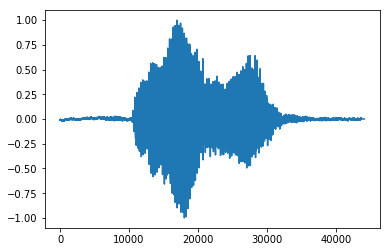

In [22]:
path = "Dataset_30_Sep/S01.05.09.wav"
data = process_audio(path)

In [23]:
ipd.Audio(path) # load a local WAV file

## Depolyment

In [0]:
model.save('keras.h5')

In [0]:
!pip install tensorflowjs

In [0]:
!tensorflowjs_converter --quantization_bytes 1 --input_format keras keras.h5 model/

In [0]:
!zip -r model.zip model/

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 23%)
  adding: model/model.json (deflated 86%)
